## The QLBS model for a European option

Welcome to your 2nd assignment in Reinforcement Learning in Finance. In this exercise you will arrive to an option price and the hedging portfolio via standard toolkit of Dynamic Pogramming (DP).
QLBS model learns both the optimal option price and optimal hedge directly from trading data.

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- When encountering **```# dummy code - remove```** please replace this code with your own 


**After this assignment you will:**
 - Re-formulate option pricing and hedging method using the language of Markov Decision Processes (MDP)
 - Setup foward simulation using Monte Carlo
 - Expand optimal action (hedge) $a_t^\star(X_t)$ and optimal Q-function $Q_t^\star(X_t, a_t^\star)$ in basis functions with time-dependend coefficients

Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [32]:
#import warnings
#warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
import grading

In [33]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="wLtf3SoiEeieSRL7rCBNJA" 
all_parts=["15mYc", "h1P6Y", "q9QW7","s7MpJ","Pa177"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [49]:
COURSERA_TOKEN = 'WHpQDqS4d2qxE1oy' # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL ='wudig159@163.com' # the email

## Parameters for MC simulation of stock prices

In [35]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity

T = 24        # number of time steps
N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

Based on simulated stock price $S_t$ paths, compute state variable $X_t$ by the following relation.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Also compute

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plots of 5 stock price $S_t$ and state variable $X_t$ paths are shown below.

In [36]:
# make a dataset
starttime = time.time()
np.random.seed(42)

# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')
S.head()


Time Cost: 0.1882636547088623 seconds


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1,100,101.696559,101.430577,103.629341,108.751794,108.149367,107.550330,113.060925,115.936104,114.466148,...,102.939537,101.345950,98.410057,99.522068,96.949628,92.996637,97.422195,96.907381,97.264872,93.263484
2,100,98.505907,99.000748,95.726977,96.990990,95.377427,94.682128,93.103932,98.696078,98.814714,...,86.840969,87.507168,89.652951,90.270233,90.096504,89.413937,85.594484,83.863861,82.822954,85.685829
3,100,101.220964,96.056697,97.171378,96.187566,94.366700,96.306087,99.555362,102.600519,100.159297,...,98.767014,95.368856,97.929230,102.246428,102.186093,105.544954,106.892574,104.971224,106.310735,111.617005
4,100,100.051777,105.131258,97.184501,99.822274,100.250413,99.497307,99.938476,94.189877,93.709657,...,97.330819,98.474356,97.046498,98.742984,99.196955,102.348174,100.333452,99.492392,98.463897,94.301182
5,100,101.073863,102.049634,102.230539,101.662886,97.508561,96.416291,95.564014,93.395791,93.085881,...,96.114051,96.191239,96.524517,104.254257,103.809496,104.941704,104.999623,101.472521,105.255873,107.881349


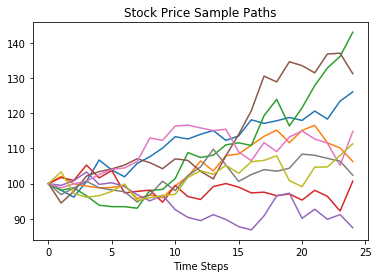

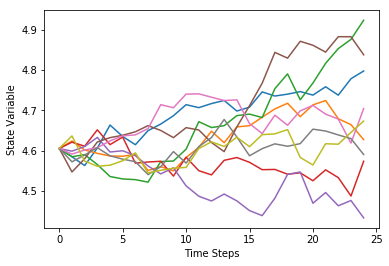

In [37]:
# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)

plt.plot(S.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

Define function *terminal_payoff* to compute the terminal payoff of a European put option.

$$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [38]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

In [39]:
type(delta_S)

pandas.core.frame.DataFrame

##  Define spline basis functions  

X.shape =  (10000, 25)
X_min, X_max =  4.0249235249 5.19080277513
Number of points k =  17


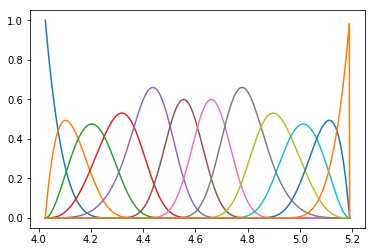

In [40]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
        
f = plt.figure()
# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [41]:
type(basis)

bspline.bspline.Bspline

In [42]:
X.values.shape

(10000, 25)

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [43]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()
# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (25, 10000, 12)
Computational time: 60.71075510978699 seconds


In [44]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)

In [45]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(25, 10000, 12)
17


## Dynamic Programming solution for QLBS 

The MDP problem in this case is to solve the following Bellman optimality equation for the action-value function.

$$Q_t^\star\left(x,a\right)=\mathbb{E}_t\left[R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\space|\space X_t=x,a_t=a\right],\space\space t=0,...,T-1,\quad\gamma=e^{-r\Delta t}$$

where $R_t\left(X_t,a_t,X_{t+1}\right)$ is the one-step time-dependent random reward and $a_t\left(X_t\right)$ is the action (hedge).

Detailed steps of solving this equation by Dynamic Programming are illustrated below.

With this set of basis functions $\left\{\Phi_n\left(X_t^k\right)\right\}_{n=1}^N$, expand the optimal action (hedge) $a_t^\star\left(X_t\right)$ and optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ in basis functions with time-dependent coefficients.
$$a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T−1,...,0$. 

Coefficients for expansions of the optimal action $a_t^\star\left(X_t\right)$ are solved by

$$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

where $\mathbf A_t$ and $\mathbf B_t$ are matrix and vector respectively with elements given by

$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$

$$\Delta S_t=S_{t+1} - e^{-r\Delta t} S_t\space \quad t=T-1,...,0$$
where $\Delta\hat{S}_t$ is the sample mean of all values of $\Delta S_t$.

Define function *function_A* and *function_B* to compute the value of matrix $\mathbf A_t$ and vector $\mathbf B_t$.

## Define the option strike and risk aversion parameter

In [46]:
risk_lambda = 0.001 # risk aversion
K = 100             # option stike  

# Note that we set coef=0 below in function function_B_vec. This correspond to a pure risk-based hedging

In [47]:
X_mat = data_mat_t[t, :, :]
num_basis_funcs = X_mat.shape[1]
print(num_basis_funcs)

12


### Part 1 Calculate coefficients  $\phi_{nt}$ of the optimal action $a_t^\star\left(X_t\right)$

**Instructions:**
- implement function_A_vec() which computes $A_{nm}^{\left(t\right)}$ matrix
- implement function_B_vec() which computes $B_n^{\left(t\right)}$ column vector

In [48]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """
    
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # store result in A_mat for grading
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    hat_dS2 = (delta_S_hat.loc[:, t] ** 2).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    
    ### END CODE HERE ###
    return A_mat
   
        
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat=delta_S_hat, 
                   S=S, 
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    Return:
    np.array() of dimension num_basis x 1
    """
    # coef = 1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # store result in B_vec for grading 
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t])
    
    ### END CODE HERE ###
    return B_vec

In [50]:
### GRADED PART (DO NOT EDIT) ###
reg_param = 1e-3
np.random.seed(42)

A_mat = function_A_vec(T-1, delta_S_hat, data_mat_t, reg_param)
idx_row = np.random.randint(low=0, high=A_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=A_mat.shape[1], size=50)


part_1 = list(A_mat[idx_row, idx_col])
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)


submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)
A_mat[idx_row, idx_col]
### GRADED PART (DO NOT EDIT) ###

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Submission successful, please check on the coursera grader page for the status


array([ 12261.42554869,   1259.28492179,    176.92982137,  11481.78830269,
         6579.62177219,  12261.42554869,    628.29798339,    189.70711815,
        12261.42554869,    176.92982137,    176.92982137,  11481.78830269,
         6579.62177219,   1259.28492179,  11481.78830269,  11481.78830269,
          189.70711815,  10408.62274335,   6579.62177219,     18.31727282,
        11481.78830269,     32.94988345,  10408.62274335,     18.31727282,
           32.94988345,   6579.62177219,     16.09789819,     32.94988345,
          628.29798339,  10408.62274335,     32.94988345,   3275.69869791,
           16.09789819,    176.92982137,    176.92982137,    628.29798339,
           32.94988345,     32.94988345,    189.70711815,     32.94988345,
        12261.42554869,   1259.28492179,   3275.69869791,    189.70711815,
         6579.62177219,    189.70711815,  12261.42554869,   6579.62177219,
         3275.69869791,  12261.42554869])

In [51]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
risk_lambda = 0.001
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])
B_vec = function_B_vec(T-1, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)

part_2 = list(B_vec)
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)


submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)

B_vec
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([  3.29073713e+01,  -2.95729027e+02,  -8.73272905e+02,
        -3.31856654e+03,  -1.25928899e+04,  -1.14032852e+04,
        -2.91636810e+03,  -3.38216415e+00,  -1.33830723e+02,
        -1.36875328e+02,  -6.60942460e+01,  -3.07904971e+01])

## Compute optimal hedge and portfolio value

Call *function_A* and *function_B* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action $a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $a_T^\star\left(X_T\right)=0$.

Once the optimal hedge $a_t^\star\left(X_t\right)$ is computed, the portfolio value $\Pi_t$ could also be computed backward recursively by 

$$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$

together with the terminal condition $\Pi_T=H_T\left(S_T\right)=\max\left(K-S_T,0\right)$ for a European put option.

Also compute $\hat{\Pi}_t=\Pi_t-\bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

Plots of 5 optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ paths are shown below.

In [52]:
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3 # free parameter
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    
    # coefficients for expansions of the optimal action
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])
    
a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')

endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Computational time: 2.4573473930358887 seconds


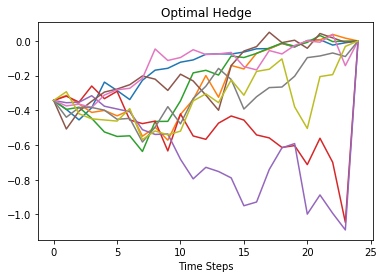

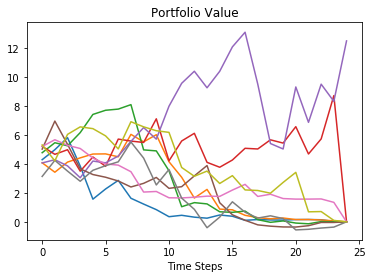

In [53]:
# plot 10 paths
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

## Compute rewards for all paths

Once the optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ are all computed, the reward function $R_t\left(X_t,a_t,X_{t+1}\right)$ could then be computed by

$$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=0,...,T-1$$

with terminal condition $R_T=-\lambda Var\left[\Pi_T\right]$.

Plot of 5 reward function $R_t$ paths is shown below.


Time Cost: 0.29799580574035645 seconds


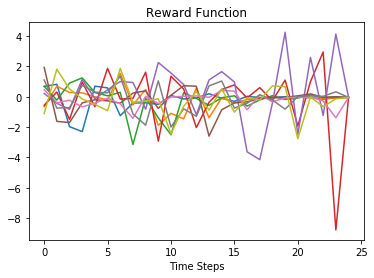

In [54]:

# Compute rewards for all paths
starttime = time.time()
# reward function
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1])

for t in range(T):
    R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t])

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')
  
# plot 10 paths
plt.plot(R.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Reward Function')
plt.show()

## Part 2: Compute the optimal Q-function with the DP approach 


Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$\omega_t=\mathbf C_t^{-1}\mathbf D_t$$

where $\mathbf C_t$ and $\mathbf D_t$ are matrix and vector respectively with elements given by

$$C_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)}\quad\quad D_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left(R_t\left(X_t,a_t^\star,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

Define function *function_C* and *function_D* to compute the value of matrix $\mathbf C_t$ and vector $\mathbf D_t$.

**Instructions:**
- implement function_C_vec() which computes $C_{nm}^{\left(t\right)}$ matrix
- implement function_D_vec() which computes $D_n^{\left(t\right)}$ column vector

In [55]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar
    
    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # your code here ....
    # C_mat = your code here ...
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    
    ### END CODE HERE ###
    return C_mat
   
def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    
    Return:
    D_vec - np.array of dimension num_basis x 1
    """
    
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # your code here ....
    # D_vec = your code here ...
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    
    ### END CODE HERE ###
    return D_vec

In [56]:
### GRADED PART (DO NOT EDIT) ###
C_mat = function_C_vec(T-1, data_mat_t, reg_param)
np.random.seed(42)
idx_row = np.random.randint(low=0, high=C_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=C_mat.shape[1], size=50)

part_3 = list(C_mat[idx_row, idx_col])
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)


submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)

C_mat[idx_row, idx_col]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([  1.09774699e+03,   2.10343651e+02,   4.56877655e+00,
         8.41911156e+02,   8.69395802e+02,   1.09774699e+03,
         3.30191775e+01,   3.53203253e+01,   1.09774699e+03,
         4.56877655e+00,   4.56877655e+00,   8.41911156e+02,
         8.69395802e+02,   2.10343651e+02,   8.41911156e+02,
         8.41911156e+02,   3.53203253e+01,   1.10328718e+03,
         8.69395802e+02,   4.35986560e+00,   8.41911156e+02,
         1.04949534e+00,   1.10328718e+03,   4.35986560e+00,
         1.04949534e+00,   8.69395802e+02,   2.34165631e+00,
         1.04949534e+00,   3.30191775e+01,   1.10328718e+03,
         1.04949534e+00,   1.99059232e+02,   2.34165631e+00,
         4.56877655e+00,   4.56877655e+00,   3.30191775e+01,
         1.04949534e+00,   1.04949534e+00,   3.53203253e+01,
         1.04949534e+00,   1.09774699e+03,   2.10343651e+02,
         1.99059232e+02,   3.53203253e+01,   8.69395802e+02,
         3.53203253e+01,   1.09774699e+03,   8.69395802e+02,
         1.99059232e+02,

In [57]:
### GRADED PART (DO NOT EDIT) ###
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])
D_vec = function_D_vec(T-1, Q, R, data_mat_t,gamma)


part_4 = list(D_vec)
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)


submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)

D_vec
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -1.33721037e+02,  -5.99514760e+02,  -3.18661973e+03,
        -1.02120353e+04,  -1.76323018e+04,  -7.20169691e+03,
        -1.13250111e+03,  -1.66673355e+02,  -5.20254025e+01,
        -1.55950276e+01,  -5.86197625e+00,  -4.96858215e+00])

Call *function_C* and *function_D* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.


Time Cost: 1.1933577060699463 seconds


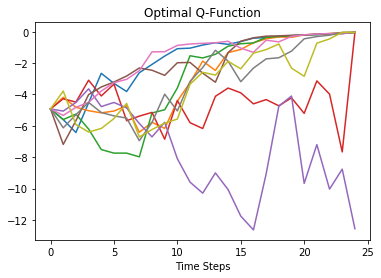

In [58]:
starttime = time.time()

# Q function
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

reg_param = 1e-3
for t in range(T-1, -1, -1):
    ######################
    C_mat = function_C_vec(t,data_mat_t,reg_param)
    D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec)
    
    Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega)
    
Q = Q.astype('float')
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
plt.plot(Q.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Q-Function')
plt.show()

The QLBS option price is given by $C_t^{\left(QLBS\right)}\left(S_t,ask\right)=-Q_t\left(S_t,a_t^\star\right)$


## Summary of the QLBS pricing and comparison with the BSM pricing 

Compare the QLBS price to European put price given by Black-Sholes formula.

$$C_t^{\left(BS\right)}=Ke^{-r\left(T-t\right)}\mathcal N\left(-d_2\right)-S_t\mathcal N\left(-d_1\right)$$

In [59]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price


## The DP solution for QLBS

-------------------------------------------
       QLBS Option Pricing (DP solution)      
-------------------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.03
Risk aversion parameter:  0.001
Strike:                   100
Maturity:                 1

QLBS Put Price:           4.9261

Black-Sholes Put Price:   4.5296




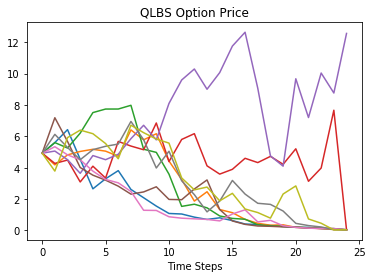

In [60]:
# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print('       QLBS Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')

# plot 10 paths
plt.plot(C_QLBS.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('QLBS Option Price')
plt.show()

In [61]:
### GRADED PART (DO NOT EDIT) ###

part5 = str(C_QLBS.iloc[0,0])
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:5],all_parts,submissions)

C_QLBS.iloc[0,0]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


4.9261254196458246

### make a summary picture

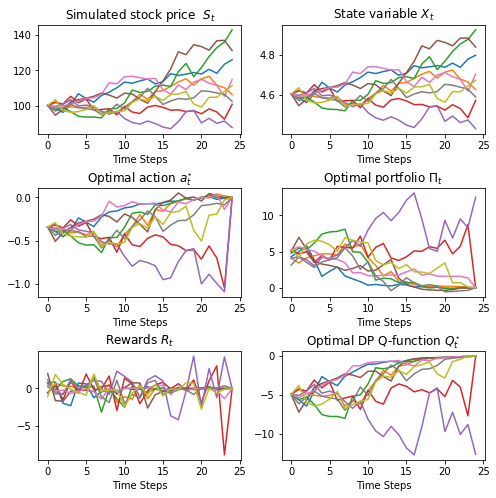

In [62]:
# plot: Simulated S_t and X_t values
# optimal hedge and portfolio values
# rewards and optimal Q-function

f, axarr = plt.subplots(3, 2)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

axarr[0, 0].plot(S.T.iloc[:,idx_plot]) 
axarr[0, 0].set_xlabel('Time Steps')
axarr[0, 0].set_title(r'Simulated stock price  $S_t$')

axarr[0, 1].plot(X.T.iloc[:,idx_plot]) 
axarr[0, 1].set_xlabel('Time Steps')
axarr[0, 1].set_title(r'State variable $X_t$')

axarr[1, 0].plot(a.T.iloc[:,idx_plot]) 
axarr[1, 0].set_xlabel('Time Steps')
axarr[1, 0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1, 1].plot(Pi.T.iloc[:,idx_plot]) 
axarr[1, 1].set_xlabel('Time Steps')
axarr[1, 1].set_title(r'Optimal portfolio $\Pi_t$')

axarr[2, 0].plot(R.T.iloc[:,idx_plot]) 
axarr[2, 0].set_xlabel('Time Steps')
axarr[2, 0].set_title(r'Rewards $R_t$') 

axarr[2, 1].plot(Q.T.iloc[:,idx_plot]) 
axarr[2, 1].set_xlabel('Time Steps')
axarr[2, 1].set_title(r'Optimal DP Q-function $Q_t^{\star}$')


# plt.savefig('QLBS_DP_summary_graphs_ATM_option_mu=r.png', dpi=600)
# plt.savefig('QLBS_DP_summary_graphs_ATM_option_mu>r.png', dpi=600)
plt.savefig('QLBS_DP_summary_graphs_ATM_option_mu>r.png', dpi=600)

plt.show()

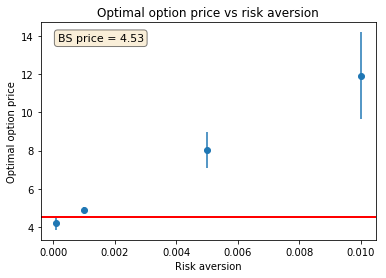

In [63]:
# plot convergence to the Black-Scholes values

# lam = 0.0001, Q = 4.1989 +/- 0.3612 # 4.378
# lam = 0.001: Q = 4.9004 +/- 0.1206  # Q=6.283
# lam = 0.005: Q = 8.0184 +/- 0.9484 # Q = 14.7489
# lam = 0.01: Q = 11.9158 +/- 2.2846 # Q = 25.33

lam_vals = np.array([0.0001, 0.001, 0.005, 0.01])
# Q_vals =  np.array([3.77, 3.81, 4.57, 7.967,12.2051])
Q_vals =  np.array([4.1989, 4.9004, 8.0184, 11.9158])
Q_std =  np.array([0.3612,0.1206, 0.9484, 2.2846])

BS_price = bs_put(0)

# f, axarr = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1)

f.subplots_adjust(hspace=.5)
f.set_figheight(4.0)
f.set_figwidth(4.0)

# ax.plot(lam_vals,Q_vals) 
ax.errorbar(lam_vals, Q_vals, yerr=Q_std, fmt='o')

ax.set_xlabel('Risk aversion')
ax.set_ylabel('Optimal option price')
ax.set_title(r'Optimal option price vs risk aversion')
ax.axhline(y=BS_price,linewidth=2, color='r')
textstr = 'BS price = %2.2f'% (BS_price)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
plt.savefig('Opt_price_vs_lambda_Markowitz.png')
plt.show()